# Client Retention Demo Using Python
In this demo, we will show Anaconda functionality on IBM LinuxONE accessing data from CSV files. The data in customer CSV consists of 6,001 rows of customer information.  The data in transaction CSV consists of 20,000 rows of transaction data. The data is transformed and joined in a Pandas DataFrame, which is used to perform exploratory analyses. A random forest algorithm is then used to predict customer churn.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

## Load Data from CSVs to Pandas DataFrames
This step will load the CSV files into Pandas DataFrames. 

***Credit card transactions***

Load credit card transactions into a Pandas DataFrame.

In [2]:
txn_df = pd.read_csv('transactions.csv')
print(txn_df.columns)

Index(['DATE_CREDIT', 'ENV_NAME', 'ENV_ID', 'ENV_TYPE', 'ENV_CPL_PAN',
       'CARD_BRND', 'TX_MRCHNT_ID', 'TX_TOTAL_AMT', 'CONT_ID', 'POSTAL_CODE',
       'AGE', 'AUTHORRESULT', 'FRAUD_VER_RESULT'],
      dtype='object')


In [3]:
txn_df['TX_TOTAL_AMT'] = pd.to_numeric(txn_df['TX_TOTAL_AMT'])
txn_df['CONT_ID'] = txn_df['CONT_ID'].astype('int64')
txn_df['DATE_CREDIT'] = pd.to_datetime(txn_df['DATE_CREDIT'])

In [4]:
txn_df['date'] = txn_df['DATE_CREDIT'].apply(lambda x: x.date())
txn_df

,DATE_CREDIT,ENV_NAME,ENV_ID,ENV_TYPE,ENV_CPL_PAN,CARD_BRND,TX_MRCHNT_ID,TX_TOTAL_AMT,CONT_ID,POSTAL_CODE,AGE,AUTHORRESULT,FRAUD_VER_RESULT,date
0,2013-04-03 00:47:00.001000+02:00,BancaItaliana,C0120580917273555,Don't be alone,1009549375,Visa Gold,7273,84.87,1009549370,C012058091,51,APPR,N,2013-04-03
1,2013-01-19 18:55:12.001000+02:00,BancaItaliana,C0120580915621418,Donna Elegante,1009549375,Visa Gold,5621,179.43,1009549370,C012058091,51,APPR,N,2013-01-19
2,2013-06-03 19:58:05.001000+02:00,BancaItaliana,C0120580915311606,Rinascimento,1009549375,Visa Gold,5311,140.34,1009549370,C012058091,51,APPR,N,2013-06-03
3,2013-06-03 00:02:00.001000+02:00,BancaItaliana,C0120580915814746,Eat and Go,1009549375,Visa Gold,5814,144.10,1009549370,C012058091,51,APPR,N,2013-06-03
4,2013-03-02 16:00:00.001000+02:00,BancaItaliana,C0120580915992763,Florists,1009549375,Visa Gold,5992,111.73,1009549370,C012058091,51,APPR,N,2013-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2013-03-27 18:00:00.001000+02:00,BancaItaliana,C01707603959502,Home of Crystal,1009533713,Debit Card,5950,20.05,1009533710,C017076039,51,APPR,N,2013-03-27
19996,2013-08-04 16:38:12.008000+02:00,BancaItaliana,C01707603978321,Movies,1009533713,Debit Card,7832,24.91,1009533710,C017076039,51,APPR,N,2013-08-04
19997,2013-09-11 18:00:00.001000+02:00,BancaItaliana,C01707603957191,My Beatiful House,1009533713,Debit Card,5719,31.35,1009533710,C017076039,51,APPR,N,2013-09-11
19998,2013-09-04 18:00:00.001000+02:00,BancaItaliana,C01707603959501,Home of Crystal,1009533713,Debit Card,5950,13.15,1009533710,C017076039,51,APPR,N,2013-09-04


***Client Data***

Load client data into a Pandas DataFrame.

In [5]:
client_df = pd.read_csv('clients.csv')
client_df = client_df.set_index("CONT_ID")
client_df

,GENDER,AGE_YEARS,HIGHEST_EDU,ANNUAL_INVEST,ANNUAL_INCOME,ACTIVITY_LEVEL,CHURN,RECORD_ID
CONT_ID,,,,,,,,
1009520370,1,63.23,4,0.0,13035.0,3,0,0
1009520380,1,58.51,1,0.0,18267.0,0,0,600
1009520390,0,31.10,2,111192.0,129276.0,2,0,1200
1009520400,0,49.84,1,0.0,17867.0,2,0,1800
1009520410,1,53.33,1,0.0,17576.0,1,0,2400
...,...,...,...,...,...,...,...,...
1009580330,0,55.02,1,0.0,21324.0,1,0,3638448
1009580340,1,26.44,1,0.0,19635.0,2,1,3639048
1009580350,1,45.64,4,14742.0,48977.0,1,0,3639648


## Aggregate statistics
Calculate a few aggregate statistics based on credit transactions and join the results to the client data DataFrame.

In [6]:
# Total transactions per customer
total_txns_df = txn_df.groupby('CONT_ID').size().rename("total_txns").to_frame()
client_df = total_txns_df.join(client_df)

In [7]:
# Total transaction amounts per customer
total_txn_amount_df = txn_df.groupby('CONT_ID')['TX_TOTAL_AMT'].sum().rename("total_txn_amount").to_frame()
client_df = client_df.join(total_txn_amount_df)

In [8]:
# Average transaction amounts per customer
avg_txn_amount_df = txn_df.groupby('CONT_ID')['TX_TOTAL_AMT'].mean().rename("avg_txn_amount").to_frame()
client_df = client_df.join(avg_txn_amount_df)

In [9]:
# Average daily transactions per customer
daily_txns = txn_df.groupby(['date', 'CONT_ID']).size()

In [10]:
# Missing transactions on a particular day means customer had none.
# These days should be included in the average as 0 transaction days.
avg_daily_txns_df = daily_txns.unstack().fillna(0).mean().rename("avg_daily_txns").to_frame()
client_df = client_df.join(avg_daily_txns_df)
client_df

,total_txns,GENDER,AGE_YEARS,HIGHEST_EDU,ANNUAL_INVEST,ANNUAL_INCOME,ACTIVITY_LEVEL,CHURN,RECORD_ID,total_txn_amount,avg_txn_amount,avg_daily_txns
CONT_ID,,,,,,,,,,,,
1009525770,104,1,24.50,1,0.0,22318.0,2,0,327680,4159.56,39.995769,0.284932
1009526100,244,1,71.56,1,0.0,23688.0,0,1,347480,10196.84,41.790328,0.668493
1009526540,69,0,39.86,1,0.0,22628.0,3,0,374248,3591.61,52.052319,0.189041
1009526580,48,1,85.43,1,0.0,16787.0,4,0,376648,1353.68,28.201667,0.131507
1009526770,69,0,66.09,4,13244.0,44395.0,2,0,388048,4986.94,72.274493,0.189041
...,...,...,...,...,...,...,...,...,...,...,...,...
1009578130,101,1,51.61,1,0.0,19129.0,3,0,3504608,3589.87,35.543267,0.276712
1009578550,238,1,65.58,1,0.0,16817.0,2,0,3530176,7809.92,32.814790,0.652055
1009578760,242,1,25.41,1,0.0,16971.0,5,0,3543144,7642.24,31.579504,0.663014


### Exploratory Analyses
We begin our exploration of the data set by creating a scatterplot of ANNUAL_INCOME vs. AGE_YEARS and their associated histograms. Matplotlib and Seaborn are two common plotting libraries used in Python.  These plotting libraries are useful in creating custom visualizations to help gain insights from our data.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [12]:
def jointplot(x, y, data, **kwargs):
    size = kwargs.pop('size', 10)
    alpha = kwargs.pop('alpha', 0.3)
    return sns.jointplot(x=x, y=y, data=data, 
                         alpha=alpha,
                         size=size,
                         **kwargs)

# for widget
def w_jointplot(x, y):
    g = jointplot(x, y, filter_outliers(client_df, by_col=y))
    plt.close()
    return g.fig

In [13]:
churn_labels = ['Did not churn', 'Did churn']

def filter_outliers(d, by_col=None):
    if isinstance(d, pd.
                  Series):
        return d[((d-d.mean()).abs()<=3*d.std())]
    elif isinstance(d, pd.DataFrame):
        if not by_col:
            raise ValueError('by_col is required for DataFrame')
        return d[np.abs(d[by_col]-d[by_col].mean())<=(3*d[by_col].std())] 

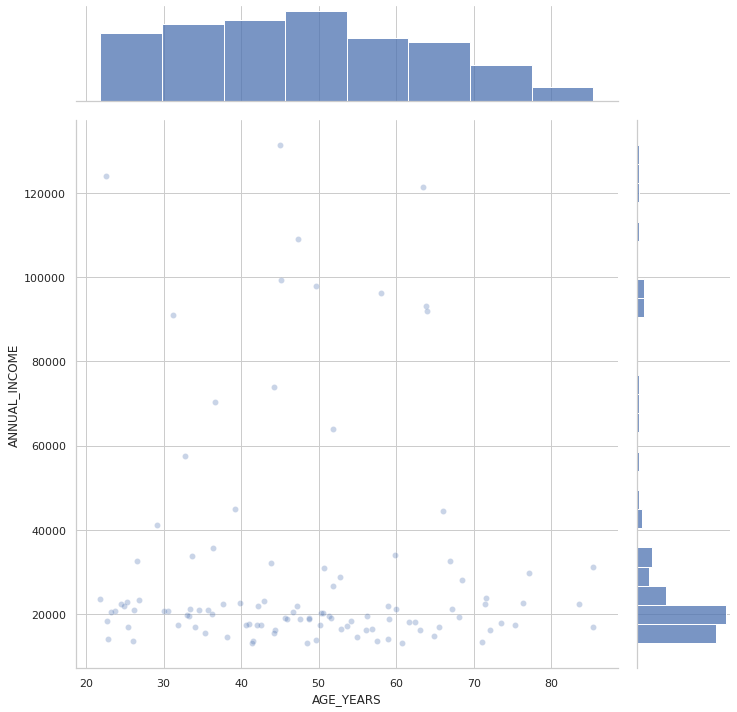

In [14]:
ax = jointplot('AGE_YEARS', 'ANNUAL_INCOME', filter_outliers(client_df, by_col='ANNUAL_INCOME'))

### Correlations
Next, we compute the correlation coefficients between each variable and create a color-coded correlation matrix. 

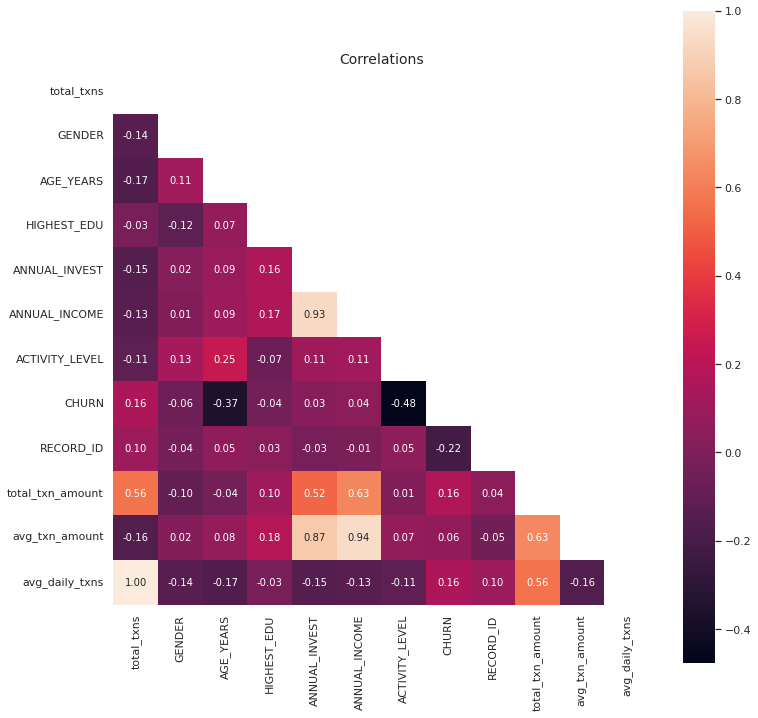

In [15]:
corr = client_df.corr()

# only show lower triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f',
                 cbar=True,
                 ax=ax)
title = ax.set_title('Correlations', size=14)

## Churn
Here we plot the distributions of clients who did and did not churn. The green histogram shows the number of clients who did churn. The blue histogram shows the number of clients who did not churn.  The line graphs show the density functions for each case. 

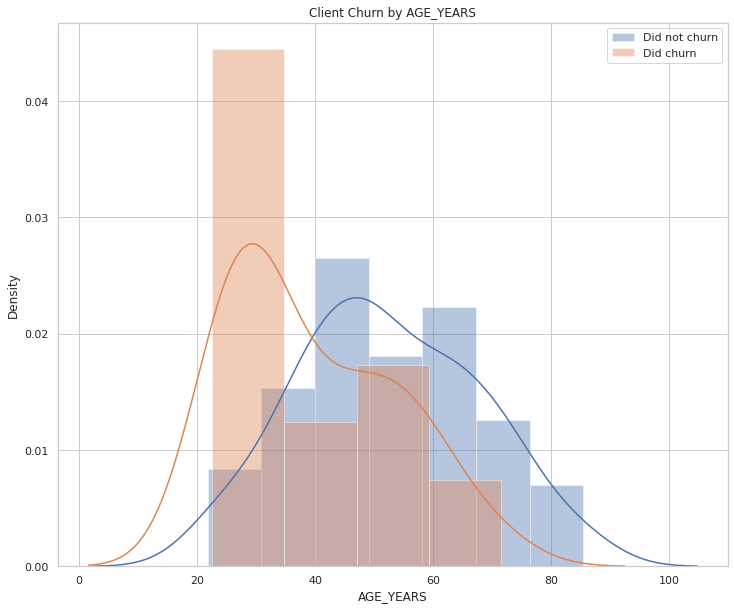

In [16]:
def plot_churn_by(df, col, **kwargs):
    f, ax = plt.subplots(figsize=(12,10), sharex=True)
    kde = kwargs.get('kde', False)
    hist = kwargs.get('hist', False)
    for churn in df.CHURN.unique():
        sns.distplot(df[df.CHURN == churn][col], 
                     label=churn_labels[churn], 
                     kde_kws={'shade': (kde and not hist)},
                     ax=ax, 
                     **kwargs)

    ax.set_title('Client Churn by {}'.format(col))
    label = ax.set_xlabel('{}'.format(col))
    return f, ax

def w_plot_churn_by(column, hist=True, kde=False, norm_hist=False):
    df = filter_outliers(client_df, by_col=column)
    f, ax = plot_churn_by(df, column, hist=hist, kde=kde, norm_hist=norm_hist)
    plt.legend()
    plt.close()
    return f

f, ax = plot_churn_by(client_df, 'AGE_YEARS')
ax = plt.legend()

As shown in the correlation matrix above, the two features that showed a negative correlation with churn were age and activity level. Here we generate a boxplot with those two features as the axes, and churn as the category. The plot shows that clients that churn tend to be younger across all levels of activity.

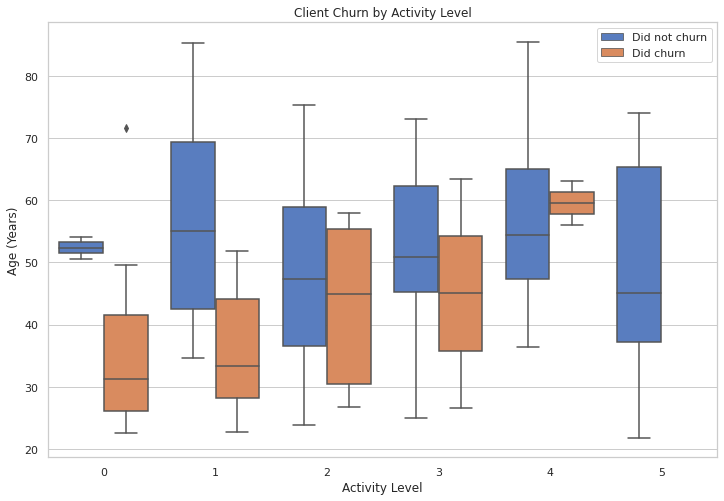

In [17]:
col = 'AGE_YEARS'
data = filter_outliers(client_df, by_col=col)

f, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x='ACTIVITY_LEVEL', y=col, hue="CHURN", data=data, 
                 palette='muted', ax=ax)
title = ax.set_title('Client Churn by Activity Level')
label = ax.set_ylabel('Age (Years)')
label = ax.set_xlabel('Activity Level')
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, churn_labels)

This beeswarm plot shows clients binned by the level of activity they maintain with the bank. Clients that churned maintained lower levels of activity (0-2). And of clients within these lower activity levels, younger clients churned more than others.

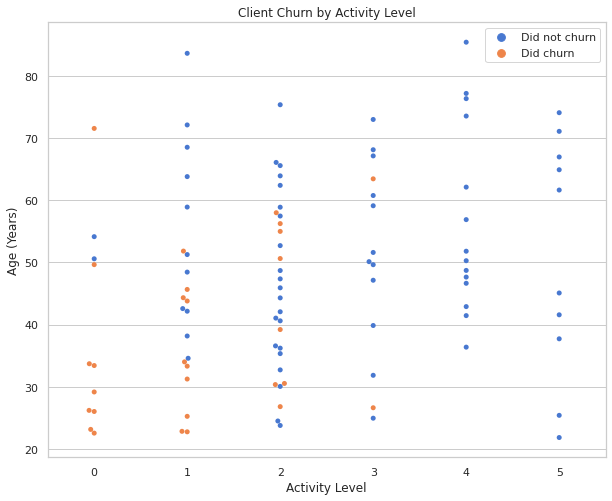

In [18]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.swarmplot(x='ACTIVITY_LEVEL', y='AGE_YEARS', hue='CHURN', 
                   data=data.sample(n=100, random_state=51), 
                   palette='muted', ax=ax)
title = ax.set_title('Client Churn by Activity Level')
label = ax.set_ylabel('Age (Years)')
label = ax.set_xlabel('Activity Level')
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, churn_labels)

## Train churn model
We now start to do some predictive analyses on the data to evaluate customer churn. To keep things simple, we use a single data set, which we split into training and test data sets. We use the training data to train the model, and the test data to make predictions about lost revenue to the bank.

We use a supervised learning algorithm, random forest, to train the model. Random Forest is a popular algorithm for both classification and regression. It requires very little tuning and is less prone to overfitting. Random forest is an aggregation of decision trees where each tree classifies an observation in a dataset. Since random forest aggregates many classifiers, it is considered an ensemble method. Using scikit learn, we create our random forest for classification. 

In [19]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [20]:
def make_feature_space(df):
    '''Create the feature space required by our classifier.'''
    # drop columns/features we don't want/need for the classifier
    features_df = df.drop(['CHURN', 'CUSTOMER_ID'], axis=1, errors='ignore')
    X = features_df.to_numpy()
    # normalize feature values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

def predict_churn(X):
    '''Predict the probabilit of churn from feature set.'''
    return clf.predict_proba(X)[:,1]

def train_model(X, y):
    '''Train our classifier using features X and target variable y.'''
    clf = RF(n_estimators=100)
    return clf.fit(X, y)

# Train the model
# split data into train, test sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(client_df, test_size=0.2)

# target variable
y = np.array(train_df['CHURN'])

# extract features
X = make_feature_space(train_df)

# train classifier
clf = train_model(X, y)

After training the model, the churn classifier and the test data set are used for our churn predictions.

In [21]:
clf

RandomForestClassifier()

## Export trained model into ONNX format 
sklearn-onnx converts models in ONNX format which can be then used to compute predictions with another backend on a different platform. sci-learn is supported on most of the platforms including IBM LinuxONE. So there is no need to do it. However for any platform specific models it's the way to expand the range of supported platforms.  A non-IBM LinuxONE can be exported to ONNX and then executed on IBM LinuxONE.

In [22]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 4]))]
onx = convert_sklearn(clf, initial_types=initial_type)
with open("customer_churn.onnx", "wb") as f:
    f.write(onx.SerializeToString())

ModuleNotFoundError: No module named 'skl2onnx'

## Calculate business loss
In this simple example, we calculate the predicted loss of business (revenue) for all clients in the test data set. We calculate the revenue from each client, and multiply that by the churn probability to determine the predicted loss.

In [ ]:
def calc_business_loss_random_forest(df):
    df['CUSTOMER_ID'] = df.index
    data = df.copy()

    # extract features
    X = make_feature_space(df)
    
    # predict churn
    data['churn_probability'] = predict_churn(X)
    
    # TODO: avg_daily_balance would be a nice feature to have here
    # for now, we'll just use fraction of income
    avg_daily_balance = df['ANNUAL_INCOME'] / 6

    # Interest made on deposits
    deposit_rate = 0.02

    # Fee collected for each credit txn
    credit_rate = 0.015

    # Assume we make some money on trading fees and/or portfolio management
    mgmt_rate = 0.02

    # How much is each customer worth to the business?
    worth = deposit_rate * avg_daily_balance + \
            mgmt_rate * df['ANNUAL_INVEST'] + \
            credit_rate * df['total_txn_amount']
    data['worth'] = worth
    
    # How much would we lose per annum?
    data['predicted_loss'] = data['churn_probability'] * worth
    
    return data.sort_values(by='predicted_loss', ascending=False)

In [ ]:
churn_df = calc_business_loss_random_forest(test_df)
churn_df.head()

## Loss by Age Group
In this section, we calculate and plot the predicted loss of revenue by age group. In our data set, age is an important feature in predicting if a client will churn. We create a DataFrame containing the cumulative predicted loss by age group.

In [ ]:
def group_by_age(df, bins=None):
    if bins is None:
        bin_size = 5
        _min, _max = int(df.AGE_YEARS.min()), int(df.AGE_YEARS.max())
        bins = range(_min, _max + bin_size, 5)
    return df.groupby(pd.cut(df.AGE_YEARS, bins=bins))

data_by_age = churn_df.pipe(group_by_age)

In [ ]:
loss_by_age_df = data_by_age['predicted_loss'].sum().reset_index()
loss_by_age_df['AGE_YEARS'] = loss_by_age_df['AGE_YEARS'].astype(str)

loss_by_age_df.plot(x='AGE_YEARS', y='predicted_loss', style='o')

## Predictive Analyses

We now start to do some predictive analyses on the data to evaluate cutomer churn based on activity level. We use a supervised learning algorithm, logistic regression, to train the model. Logistic regression is a common, fast, highly scalable, classification model that doesn't require much tuning and is easy to regularize. The model outputs a set of probabilities which can be more useful than class labels. Here, we will use PyTorch Machine Learning library to create our model.

Pytorch works with tensors. So, the first steps is to convert train and test datasets into tensors using the “torch.from_numpy()” method. The datatype should be converted into float32 before this. Which can be done using “astype()” function.

In [ ]:
import torch
scaler = MinMaxScaler()
#'ACTIVITY_LEVEL','total_txn_amount','avg_txn_amount','avg_daily_txns'
x_train=torch.from_numpy(scaler.fit_transform(train_df[['ACTIVITY_LEVEL']].astype(np.float32).values))
x_test=torch.from_numpy(scaler.fit_transform(test_df[['ACTIVITY_LEVEL']].astype(np.float32).values))
y_train=torch.from_numpy(train_df['CHURN'].astype(np.float32).values)
y_test=torch.from_numpy(test_df['CHURN'].astype(np.float32).values)
#
n_features = 1
#
y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)

Next we create a custom model in PyTorch for logistic regression. For that we define a class with the model name. This class should derive torch.nn.Module.

In [ ]:
class LogisticRegressionModel(torch.nn.Module):
 def __init__(self,no_input_features):
   super(LogisticRegressionModel,self).__init__()
   self.linear=torch.nn.Linear(no_input_features,1)
 def forward(self,x):
   y_predicted=torch.sigmoid(self.linear(x))
   return y_predicted


After defining the class, we initialize the model.

In [ ]:
lr_model=LogisticRegressionModel(n_features)

Learning rate “lr” is set to 0.01, but it's a hyperparameter that should be fine-tuned to an optimal value. The number of epochs is set to 10.

In [ ]:
criterion=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(lr_model.parameters(),lr=0.01)

number_of_epochs=1000
for epoch in range(number_of_epochs):
 optimizer.zero_grad()
 y_prediction=lr_model(x_train)
 loss=criterion(y_prediction,y_train)
 loss.backward()
 optimizer.step()
 if (epoch+1)%50 == 0 or epoch==0:
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through train dataset
    for label in y_train:
        # Get predictions and compare with the churn label
        predicted = y_prediction[total]
        #print(label, predicted, (predicted >=0.5) and (label == 1))
        total += 1
        if (predicted >=0.5) and (label == 1) or (predicted <0.5) and (label == 0) :
            correct += 1
        
        
    accuracy = 100 * correct / total
    print('epoch:', epoch+1,',loss=',loss.item(),',accuracy=',accuracy)


Now, we plot the S-curve for cutomer activity level vs. churn. Matplotlib and Seaborn are two common plotting libraries used in Python. These plotting libraries are useful in creating custom visualizations to help gain insights from our data.

In [ ]:
%matplotlib inline

y_prediction = lr_model(x_test)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")

X = test_df['ACTIVITY_LEVEL']
Y = y_prediction.detach().numpy() #test_df['CHURN']


plt.figure()
plt.xlabel("Activity Level", fontsize=16)
plt.ylabel("Probability of Churn", fontsize=16)
sns.regplot(x=np.array(X),y=np.array(Y), order=2)
plt.show()